In [26]:
import time
import copy
import glob
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import seaborn as sns

from PIL import Image
from tqdm.auto import tqdm
from torch.optim import Adam
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from torch.optim import adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, resnet34
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
train_normal = glob.glob("/content/drive/MyDrive/Pneumonia_Dataset/Train/Normal/*")
train_bacterial = glob.glob("/content/drive/MyDrive/Pneumonia_Dataset/Train/bacteria/*")
train_viral = glob.glob("/content/drive/MyDrive/Pneumonia_Dataset/Train/virus/*")

test_normal = glob.glob("/content/drive/MyDrive/Pneumonia_Dataset/Test/Normal/*")
test_bacterial = glob.glob("/content/drive/MyDrive/Pneumonia_Dataset/Test/bacteria/*")
test_viral = glob.glob("/content/drive/MyDrive/Pneumonia_Dataset/Test/virus/*")

In [8]:
train_paths = train_normal + train_bacterial + train_viral
test_paths = test_normal + test_bacterial + test_viral

In [9]:
train_labels = [0] * len(train_normal) + [1] * len(train_bacterial) + [2] * len(train_viral)
test_labels = [0] * len(test_normal) + [1] * len(test_bacterial) + [2] * len(test_viral)

In [10]:
print(len(train_paths), len(train_labels))
print(len(test_paths), len(test_labels))

3910 3910
306 306


In [11]:
train_paths, valid_paths, train_labels, valid_labels = train_test_split(train_paths, train_labels, stratify=train_labels)

In [12]:
def show_random_images():
    path_random_normal = random.choice(train_normal)
    path_random_bacterial = random.choice(train_bacterial)
    path_random_viral = random.choice(train_viral)

    fig = plt.figure(figsize=(15, 5))  # Adjust the figure size for three subplots

    ax1 = plt.subplot(1, 3, 1)  # Change the number of subplots to 1 row and 3 columns
    ax1.imshow(Image.open(path_random_normal).convert("LA"))
    ax1.set_title("Normal X-ray")

    ax2 = plt.subplot(1, 3, 2)  # Specify the position of the second subplot
    ax2.imshow(Image.open(path_random_bacterial).convert("LA"))
    ax2.set_title("Bacterial X-ray")

    ax3 = plt.subplot(1, 3, 3)  # Specify the position of the third subplot
    ax3.imshow(Image.open(path_random_viral).convert("LA"))
    ax3.set_title("Viral X-ray")

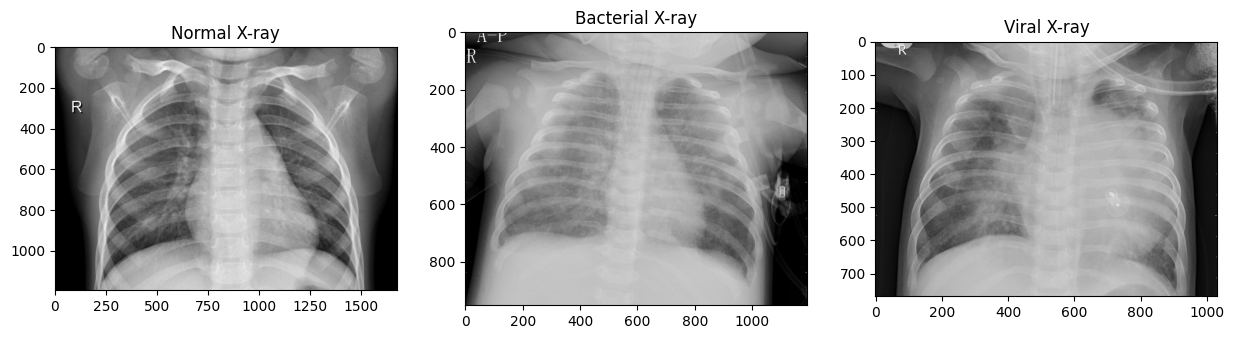

In [13]:
show_random_images()

In [14]:
class XrayDataset(Dataset):
  def __init__(self, paths, labels, transform=None):
    self.paths = paths
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.paths)

  def __getitem__(self, index):
    path = self.paths[index]
    image = Image.open(path).convert("RGB")

    if self.transform:
      image = self.transform(image)

    label = self.labels[index]
    label = torch.tensor([label])

    return image, label

In [ ]:
#train_dataset = XrayDataset(train_paths, train_labels)

In [ ]:
# len(train_dataset)

In [ ]:
# next(iter(train_dataset))

In [ ]:
# resnet = resnet18()

In [ ]:
# resnet

In [15]:
class PneumoniaNet(nn.Module):
  def __init__(self, pretrained=True):
    super(PneumoniaNet, self).__init__()
    self.backbone = resnet18(pretrained=pretrained)
    self.fc = nn.Linear(in_features=512, out_features=1)

  def forward(self, x):
    x = self.backbone.conv1(x)
    x = self.backbone.bn1(x)
    x = self.backbone.relu(x)
    x = self.backbone.maxpool(x)

    x = self.backbone.layer1(x)
    x = self.backbone.layer2(x)
    x = self.backbone.layer3(x)
    x = self.backbone.layer4(x)

    x = self.backbone.avgpool(x)

    x = x.view(x.size(0), 512)
    x = self.fc(x)

    return x

In [16]:
image_size = (500, 500)

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=15),
    transforms.Resize(size=image_size),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=image_size),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = XrayDataset(train_paths, train_labels, train_transform)
valid_dataset = XrayDataset(valid_paths, valid_labels, test_transform)

In [17]:
pretrained = True

model = PneumoniaNet(pretrained=pretrained)

lr = 3e-3

num_eppchs = 5
train_batch_size = 16
valid_batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, num_workers=5, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=valid_batch_size, num_workers=5, shuffle=False)

dataloaders = {
    "train": train_dataloader,
    "val": valid_dataloader
}

logging_steps = {
    "train": len(dataloaders["train"]) // 10,
    "val": len(dataloaders["val"]) // 10
}

dataset_size = {
    "train": len(train_dataset),
    "val": len(valid_dataset)
}

batch_sizes = {
  "train": train_batch_size,
  "val": valid_batch_size
}

criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=lr)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 183MB/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current 

In [18]:
model.cuda()

PneumoniaNet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [19]:
!nvidia-smi

Fri Jun 21 13:55:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0              26W /  70W |    167MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [20]:
def train_model(model, criterion, optimizer, num_epochs, device="cuda"):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0

    for epoch in tqdm(range(num_epochs), leave=False):
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for i, (inputs, labels) in tqdm(enumerate(dataloaders[phase]), leave=False, total=len(dataloaders[phase])):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    preds = outputs.sigmoid() > 0.5
                    loss = criterion(outputs, labels.float())

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                if i % logging_steps[phase] == 0 and i > 0:
                    avg_loss = running_loss / ((i+1) * batch_sizes[phase])
                    avg_acc = running_corrects.double() / ((i+1) * batch_sizes[phase])

                    print(f"phase: {epoch+1} / {num_epochs} loss : {avg_loss} acc: {avg_acc}")

            epoch_loss = running_loss / dataset_size[phase]
            epoch_acc = running_corrects.double() / dataset_size[phase]

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since

    print(f"training took {time_elapsed} seconds")

    model.load_state_dict(best_model_wts)

    return model

In [21]:
model = train_model(model, criterion, optimizer, num_eppchs)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

phase: 1 / 5 loss : -2.867357265008123 acc: 0.3782894736842105
phase: 1 / 5 loss : -5.937651001923793 acc: 0.40371621621621623
phase: 1 / 5 loss : -9.979218777201392 acc: 0.40795454545454546
phase: 1 / 5 loss : -14.196284378636372 acc: 0.4306506849315068
phase: 1 / 5 loss : -18.867708881805232 acc: 0.459478021978022
phase: 1 / 5 loss : -23.09370447271461 acc: 0.45470183486238536
phase: 1 / 5 loss : -32.447703748002766 acc: 0.44881889763779526
phase: 1 / 5 loss : -41.329346284989654 acc: 0.45129310344827583
phase: 1 / 5 loss : -52.299302905432285 acc: 0.4532208588957055
phase: 1 / 5 loss : -63.931676940858694 acc: 0.45062154696132595
train Loss: -66.5160 Acc: 0.4502


  0%|          | 0/62 [00:00<?, ?it/s]

phase: 1 / 5 loss : -27.062833513532365 acc: 0.46428571428571425
phase: 1 / 5 loss : -20.97871628174415 acc: 0.4567307692307693
phase: 1 / 5 loss : -19.345269460427133 acc: 0.47697368421052627
phase: 1 / 5 loss : -20.52648851752281 acc: 0.465
phase: 1 / 5 loss : -20.69775958503446 acc: 0.469758064516129
phase: 1 / 5 loss : -21.11729003529291 acc: 0.4695945945945946
phase: 1 / 5 loss : -18.47605595962946 acc: 0.4622093023255814
phase: 1 / 5 loss : -17.80544062475769 acc: 0.471938775510204
phase: 1 / 5 loss : -15.496403557062148 acc: 0.4795454545454545
phase: 1 / 5 loss : -14.769579927940837 acc: 0.4764344262295082
val Loss: -14.7422 Acc: 0.4765



  0%|          | 0/184 [00:00<?, ?it/s]

phase: 2 / 5 loss : -229.48408347681948 acc: 0.48026315789473684
phase: 2 / 5 loss : -264.06387950278616 acc: 0.4611486486486487
phase: 2 / 5 loss : -314.5757332715121 acc: 0.44999999999999996
phase: 2 / 5 loss : -325.6566887555057 acc: 0.4511986301369863
phase: 2 / 5 loss : -353.032307603857 acc: 0.4443681318681319
phase: 2 / 5 loss : -394.8075459769013 acc: 0.4438073394495413
phase: 2 / 5 loss : -426.6882019418431 acc: 0.44291338582677164
phase: 2 / 5 loss : -466.7267422972054 acc: 0.4396551724137931
phase: 2 / 5 loss : -513.5907487518217 acc: 0.4378834355828221
phase: 2 / 5 loss : -546.6284975136183 acc: 0.4378453038674033
train Loss: -550.6177 Acc: 0.4400


  0%|          | 0/62 [00:00<?, ?it/s]

phase: 2 / 5 loss : -546.9091491699219 acc: 0.5446428571428571
phase: 2 / 5 loss : -444.9903059739333 acc: 0.5336538461538461
phase: 2 / 5 loss : -463.4864953693591 acc: 0.5526315789473684
phase: 2 / 5 loss : -444.91113082885744 acc: 0.5375
phase: 2 / 5 loss : -459.55600947718466 acc: 0.5383064516129032
phase: 2 / 5 loss : -465.6393493446144 acc: 0.5304054054054055
phase: 2 / 5 loss : -435.2376984884573 acc: 0.5290697674418604
phase: 2 / 5 loss : -420.3505352370593 acc: 0.5420918367346939
phase: 2 / 5 loss : -386.25615745891224 acc: 0.5443181818181818
phase: 2 / 5 loss : -375.9124125339946 acc: 0.5420081967213115
val Loss: -375.1508 Acc: 0.5419



  0%|          | 0/184 [00:00<?, ?it/s]

phase: 3 / 5 loss : -934.2318420410156 acc: 0.48684210526315785
phase: 3 / 5 loss : -1021.6964169064083 acc: 0.47804054054054057
phase: 3 / 5 loss : -1110.8831071333452 acc: 0.4693181818181818
phase: 3 / 5 loss : -1141.9912761531464 acc: 0.4708904109589041
phase: 3 / 5 loss : -1212.79055417239 acc: 0.4766483516483517
phase: 3 / 5 loss : -1312.307114907361 acc: 0.4747706422018349
phase: 3 / 5 loss : -1412.882988396592 acc: 0.46948818897637795
phase: 3 / 5 loss : -1522.4358686775997 acc: 0.46551724137931033
phase: 3 / 5 loss : -1607.48613434774 acc: 0.4601226993865031
phase: 3 / 5 loss : -1720.6073675840598 acc: 0.45545580110497236
train Loss: -1722.4074 Acc: 0.4557


  0%|          | 0/62 [00:00<?, ?it/s]

phase: 3 / 5 loss : -1352.5707179478236 acc: 0.5357142857142857
phase: 3 / 5 loss : -1338.0814549372747 acc: 0.5384615384615385
phase: 3 / 5 loss : -1307.4712002402857 acc: 0.5592105263157895
phase: 3 / 5 loss : -1426.2277337646485 acc: 0.55
phase: 3 / 5 loss : -1495.3367501535724 acc: 0.5564516129032258
phase: 3 / 5 loss : -1546.3080877355628 acc: 0.5489864864864865
phase: 3 / 5 loss : -1504.6760427785475 acc: 0.5450581395348837
phase: 3 / 5 loss : -1483.7254965645927 acc: 0.5599489795918366
phase: 3 / 5 loss : -1408.586319247159 acc: 0.5613636363636363
phase: 3 / 5 loss : -1380.6901355180585 acc: 0.5584016393442623
val Loss: -1383.3331 Acc: 0.5583



  0%|          | 0/184 [00:00<?, ?it/s]

phase: 4 / 5 loss : -3268.1534969932154 acc: 0.42434210526315785
phase: 4 / 5 loss : -3212.8130856075804 acc: 0.4712837837837838
phase: 4 / 5 loss : -3127.7798295454545 acc: 0.4795454545454545
phase: 4 / 5 loss : -3248.2717535985657 acc: 0.4751712328767123
phase: 4 / 5 loss : -3288.01127071171 acc: 0.48145604395604397
phase: 4 / 5 loss : -3338.4155329433056 acc: 0.48107798165137616
phase: 4 / 5 loss : -3408.944029319943 acc: 0.4763779527559055
phase: 4 / 5 loss : -3581.624143824084 acc: 0.47456896551724137
phase: 4 / 5 loss : -3635.4599347260832 acc: 0.4750766871165644
phase: 4 / 5 loss : -3796.573539607433 acc: 0.4734116022099447
train Loss: -3807.2251 Acc: 0.4748


  0%|          | 0/62 [00:00<?, ?it/s]

phase: 4 / 5 loss : -3165.6203264508927 acc: 0.5535714285714285
phase: 4 / 5 loss : -2885.7301400991587 acc: 0.5384615384615385
phase: 4 / 5 loss : -2769.0114521227383 acc: 0.5625
phase: 4 / 5 loss : -2909.7439379882812 acc: 0.56
phase: 4 / 5 loss : -3027.7103488060734 acc: 0.5665322580645161
phase: 4 / 5 loss : -3100.818578771643 acc: 0.5574324324324325
phase: 4 / 5 loss : -3064.1868598405704 acc: 0.5566860465116279
phase: 4 / 5 loss : -3010.1675738899075 acc: 0.5714285714285714
phase: 4 / 5 loss : -2876.466026722301 acc: 0.571590909090909
phase: 4 / 5 loss : -2830.351936715548 acc: 0.569672131147541
val Loss: -2836.1715 Acc: 0.5695



  0%|          | 0/184 [00:00<?, ?it/s]

phase: 5 / 5 loss : -5843.266627261513 acc: 0.4671052631578947
phase: 5 / 5 loss : -5947.238670555321 acc: 0.4628378378378379
phase: 5 / 5 loss : -6262.8131547407675 acc: 0.45454545454545453
phase: 5 / 5 loss : -6244.02353950396 acc: 0.4708904109589041
phase: 5 / 5 loss : -6193.023956634186 acc: 0.47252747252747257
phase: 5 / 5 loss : -6119.642659318556 acc: 0.47305045871559637
phase: 5 / 5 loss : -6046.498480849379 acc: 0.47687007874015747
phase: 5 / 5 loss : -6070.976272477775 acc: 0.48017241379310344
phase: 5 / 5 loss : -6262.38021045521 acc: 0.4846625766871166
phase: 5 / 5 loss : -6521.769598354951 acc: 0.4865331491712707
train Loss: -6534.9985 Acc: 0.4867


  0%|          | 0/62 [00:00<?, ?it/s]

phase: 5 / 5 loss : -6141.932826450893 acc: 0.5535714285714285
phase: 5 / 5 loss : -5799.321270282452 acc: 0.5432692307692308
phase: 5 / 5 loss : -5657.990934673108 acc: 0.5592105263157895
phase: 5 / 5 loss : -6325.332875976563 acc: 0.5525
phase: 5 / 5 loss : -6539.62168047505 acc: 0.5584677419354839
phase: 5 / 5 loss : -6748.699109876478 acc: 0.5574324324324325
phase: 5 / 5 loss : -6665.521532635356 acc: 0.5581395348837209
phase: 5 / 5 loss : -6538.470067861129 acc: 0.5688775510204082
phase: 5 / 5 loss : -6310.3635364879265 acc: 0.5659090909090909
phase: 5 / 5 loss : -6290.829147589011 acc: 0.5594262295081968
val Loss: -6307.4529 Acc: 0.5593

training took 2252.150167942047 seconds


In [22]:
len(test_paths), len(test_labels)

(306, 306)

In [23]:
test_dataset = XrayDataset(test_paths, test_labels, test_transform)

In [24]:
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=False)

In [27]:
y_pred = []
y_true = []

for i, (tensors, labels) in tqdm(enumerate(test_dataloader), leave=False, total=len(test_dataloader)):
  with torch.no_grad():
    predictions = model(tensors.cuda())
    predictions = predictions.sigmoid()
    predictions = predictions > 0.5
    y_pred.append(predictions)

    y_true.append(labels)

  0%|          | 0/10 [00:00<?, ?it/s]

In [28]:
y_pred[0]

tensor([[False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False]], device='cuda:0')

In [29]:
y_pred = torch.cat(y_pred)
y_true = torch.cat(y_true)

In [30]:
y_pred.shape, y_true.shape

(torch.Size([306, 1]), torch.Size([306, 1]))

In [31]:
y_pred = y_pred.cpu().numpy()
y_true = y_true.numpy()

In [32]:
y_pred = y_pred.astype(np.int64)
y_true = y_true.astype(np.int64)

In [33]:
y_pred = y_pred.reshape(-1)
y_true = y_true.reshape(-1)

In [34]:
y_pred.shape, y_true.shape

((306,), (306,))

In [35]:
accuracy_score(y_true, y_pred)

0.5849673202614379